In [13]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import gensim
import string
from collections import OrderedDict
from gensim import corpora, models, similarities
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt


class LDAHelper:
    """
    Current LDAHelper implementation within pipeline
    """
    def __init__(self):
        self.version = 0
        self.stopwords = [
            'RT',
            'rt'
        ] + stopwords.words('english') + list(string.punctuation)

    def clean_up(self, word):
        """
        Clean up punctuation.
        Lower case string.
        :param word: full length tweet
        :return: Cleaned up tweet
        """
        return word.translate(None, string.punctuation)

    def lemmatize_stemming(self, word_without_punctuation):
        """
        Lemmatize and stemming a word
        :param word_without_punctuation:
        :return: resulting word
        """
        stemmer = SnowballStemmer('english')
        return stemmer.stem(WordNetLemmatizer().lemmatize(word_without_punctuation, pos='v'))
    
    def valid(self, word, username):
        """
        Verify the validity of a word.
        :param word: word in a tweet
        :return: True if the word passes a set of rules. To be formalized later
        """
        return (word not in self.stopwords) and (word[:1] != '@') and (word[:4] != 'http') and (word != 'cont') and (word != username)

    def preprocess(self, tweet):
        """
        Applying lemmatization and stemming to any word that is not part of
        our stopwords
        :param tweet: Full tweet
        :return: Array of processed words
        """
        return [self.lemmatize_stemming(word)
                for word in gensim.utils.simple_preprocess(tweet, min_len=2)
                if self.valid(word, username)]
    
    def preprocess_without_LS(self, tweet, username):
        """
        Pre processing without lemmatization and stemming to test results 
        from this paper http://www.cs.cornell.edu/~xanda/winlp2017.pdf?fbclid=IwAR1v1kud8O551DJysvtuU2UC0Ra-oAAPLban_ZiKfyvN58_aWCjZUdjMQeM
        :param tweet: Full tweet
        :return: Array of processed words
        """
        return [word
                for word in gensim.utils.simple_preprocess(tweet, min_len=2)
                if self.valid(word, username)]
    

In [8]:
l = LDAHelper()
l.preprocess('So good to see that Republicans will be winning the Great State of Alabama Senate Seat back, now that lightweight Senator @DougJones cast a partisan vote for the Impeachment Hoax. Thought his boss, Cryin’ Chuck, would have forced him to vote against the Hoax. A Do Nothing Stiff!')

[u'good',
 u'see',
 u'republican',
 u'win',
 u'great',
 u'state',
 u'alabama',
 u'senat',
 u'seat',
 u'back',
 u'lightweight',
 u'senat',
 u'dougjon',
 u'cast',
 u'partisan',
 u'vote',
 u'impeach',
 u'hoax',
 u'think',
 u'boss',
 u'cryin',
 u'chuck',
 u'would',
 u'forc',
 u'vote',
 u'hoax',
 u'noth',
 u'stiff']

### PROOF OF CONCEPT
Experiment is ran on 1.6 million english tweets from users across the world. No specific topics are expected

In [2]:
# Load dataset
dataset = './training_set.csv'
tweets = pd.read_csv(dataset, encoding='latin1')
tweets = tweets['Tweet']
tweets.head(5)

IOError: File ./training_set.csv does not exist

In [ ]:
# Preprocessing all tweets
# 1. Separating a tweet into array of words
# 2. Lemmatization and stemming
# 3. Removing all stopwords, @Username, links and words of length less than 2
corpus = []
for tweet in tweets:
    corpus.append(l.preprocess_without_LS(tweet))

corpus[0:10]

In [ ]:
# 1. Transforming corpus into Dictionary (mapping of normalized words to integer ID)
# 2. Transforming each tweet into bag of words (Mapping of word to its occurence in tweet)
# 3. TDIDF (term frequency-inverse document frequency) Model created
dictionary = corpora.Dictionary(corpus)
bow_corpus = [dictionary.doc2bow(text) for text in corpus]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
# LDA Model created
total_topics = 5
lda = models.LdaModel(bow_corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[bow_corpus]

In [ ]:
lda.show_topics(total_topics, 5)

In [ ]:
# Save our model - Eventually to EC2 Instance
from gensim.test.utils import datapath

temp_file = datapath("general_tweets_NO_LS_model")
lda.save(temp_file)

In [ ]:
# Show mapping of words to topics
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

In [ ]:
g=sns.clustermap(df_lda.corr(), 
                 center=0, 
                 standard_scale=1, 
                 cmap="RdBu", 
                 metric='cosine', 
                 linewidths=.75, 
                 figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

### EXPERIMENT ON HISTORICAL DONALD TRUMP TWEETS

In [11]:
dataset = './donald_trump_tweets.csv'
tweets = pd.read_csv(dataset, encoding='latin1')
tweets.head(5)

,text
0,Thank you @BlueAngels and @AFThunderbirds! #Am...
1,RT @TomFitton: BREAKING: Emails show Obama FBI...
2,RT @nedryun: A fifth to half of all coronaviru...
3,RT @GreggJarrett: Newly Declassified Documents...
4,RT @GreggJarrett: Newly Revealed Docs Support ...


In [12]:
corpus_DT = []
username = 'realdonaldtrump'
for tweet in tweets['text']:
    corpus_DT.append(l.preprocess_without_LS(tweet, username))

corpus_DT[0:10]

[[u'thank',
  u'blueangels',
  u'afthunderbirds',
  u'americastrong',
  u'co',
  u'ozyfjbt',
  u'co',
  u'bq',
  u'vokysmd'],
 [u'tomfitton',
  u'breaking',
  u'emails',
  u'show',
  u'obama',
  u'fbi',
  u'get',
  u'genflynn',
  u'also',
  u'knew',
  u'mccain',
  u'leaked',
  u'anti',
  u'dossier',
  u'judicia\xe2'],
 [u'nedryun',
  u'fifth',
  u'half',
  u'coronavirus',
  u'deaths',
  u'nursing',
  u'homes',
  u'co',
  u'clfe'],
 [u'greggjarrett',
  u'newly',
  u'declassified',
  u'documents',
  u'show',
  u'john',
  u'kerry\xe2',
  u'state',
  u'department',
  u'spread',
  u'russia',
  u'collusion',
  u'narrative',
  u'co',
  u'glrdt'],
 [u'greggjarrett',
  u'newly',
  u'revealed',
  u'docs',
  u'support',
  u'flynn\xe2',
  u'innocence',
  u'case',
  u'tossed',
  u'co',
  u'znfzz',
  u'vuy'],
 [u'love',
  u'diamond',
  u'amp',
  u'silk',
  u'millions',
  u'people',
  u'co',
  u'rbx',
  u'bmfiwh'],
 [u'whitehouse',
  u'days',
  u'ago',
  u'business',
  u'leaders',
  u'joined',
  u'pr

In [13]:
dictionary = corpora.Dictionary(corpus_DT)
bow_corpus = [dictionary.doc2bow(text) for text in corpus_DT]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [14]:
total_topics = 5
lda = models.LdaModel(corpus_tfidf, 
                      id2word=dictionary, 
                      num_topics=total_topics)
corpus_lda = lda[corpus_tfidf]

In [15]:
lda.show_topics(total_topics,10)

[(0,
  u'0.016*"barackobama" + 0.006*"china" + 0.004*"timetogettough" + 0.004*"us" + 0.004*"deal" + 0.004*"great" + 0.003*"co" + 0.003*"obama" + 0.003*"thanks" + 0.003*"nbc"'),
 (1,
  u'0.007*"obamacare" + 0.004*"iraq" + 0.004*"thoughts" + 0.004*"yankees" + 0.003*"co" + 0.003*"greta" + 0.003*"newsmax" + 0.003*"club" + 0.003*"nbc" + 0.003*"thinking"'),
 (2,
  u'0.006*"apprentice" + 0.006*"obama" + 0.006*"interview" + 0.005*"mittromney" + 0.004*"good" + 0.004*"debt" + 0.004*"bit" + 0.004*"celebrity" + 0.003*"show" + 0.003*"tonight"'),
 (3,
  u'0.006*"golf" + 0.005*"tune" + 0.004*"pm" + 0.004*"happy" + 0.004*"true" + 0.004*"course" + 0.003*"trump" + 0.003*"israel" + 0.003*"birthday" + 0.003*"thanks"'),
 (4,
  u'0.012*"thanks" + 0.010*"ly" + 0.009*"com" + 0.006*"miss" + 0.006*"trump" + 0.006*"co" + 0.005*"great" + 0.004*"thank" + 0.004*"donald" + 0.004*"hotel"')]

In [16]:
lda.top_topics(corpus=corpus_tfidf, dictionary=dictionary, texts=corpus_DT, coherence='c_uci')

[([(0.006148063, u'apprentice'),
   (0.0056667323, u'obama'),
   (0.0055652014, u'interview'),
   (0.004901784, u'mittromney'),
   (0.004137309, u'good'),
   (0.004113694, u'debt'),
   (0.0040586, u'bit'),
   (0.0035566657, u'celebrity'),
   (0.0033077241, u'show'),
   (0.0032950966, u'tonight'),
   (0.0030002424, u'great'),
   (0.002976749, u'discussing'),
   (0.0029714922, u'like'),
   (0.0029627206, u'trump'),
   (0.002937861, u'donald'),
   (0.0028761628, u'co'),
   (0.002867049, u'get'),
   (0.0028659308, u'time'),
   (0.0028218897, u'think'),
   (0.0028188713, u'amp')],
  -0.8435790617640403),
 ([(0.015541873, u'barackobama'),
   (0.0055380715, u'china'),
   (0.0040282924, u'timetogettough'),
   (0.003924779, u'us'),
   (0.0038634662, u'deal'),
   (0.0037089267, u'great'),
   (0.0034871325, u'co'),
   (0.0031774053, u'obama'),
   (0.0029815705, u'thanks'),
   (0.0029555047, u'nbc'),
   (0.0029239873, u'trump'),
   (0.0027456123, u'art'),
   (0.0027289016, u'trumpvlog'),
   (0.002

In [ ]:
lda.top_topics(coherence='c_v')

In [19]:
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
df_lda

,america,amp,answer,appearance,apprentice,apprenticenbc,art,awesome,barackobama,benghazi,...,tune,us,watch,wind,wishing,would,wwe,yankees,yes,youtube
0,0.002237,0.000000,0.000000,0.000000,0.000000,0.000000,0.002746,0.000000,0.015542,0.000000,...,0.000000,0.003925,0.000000,0.00000,0.000000,0.002364,0.000000,0.000000,0.002256,0.000000
1,0.000000,0.000000,0.000000,0.001727,0.000000,0.000000,0.000000,0.000000,0.000000,0.001687,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.001923,0.003523,0.000000,0.001918
2,0.000000,0.002819,0.000000,0.000000,0.006148,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.002496,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.002217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004731,0.000000,0.000000,0.00000,0.001793,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.002117,0.000000,0.000000,0.000000,0.000000,0.002075,0.000000,0.002083,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00273,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


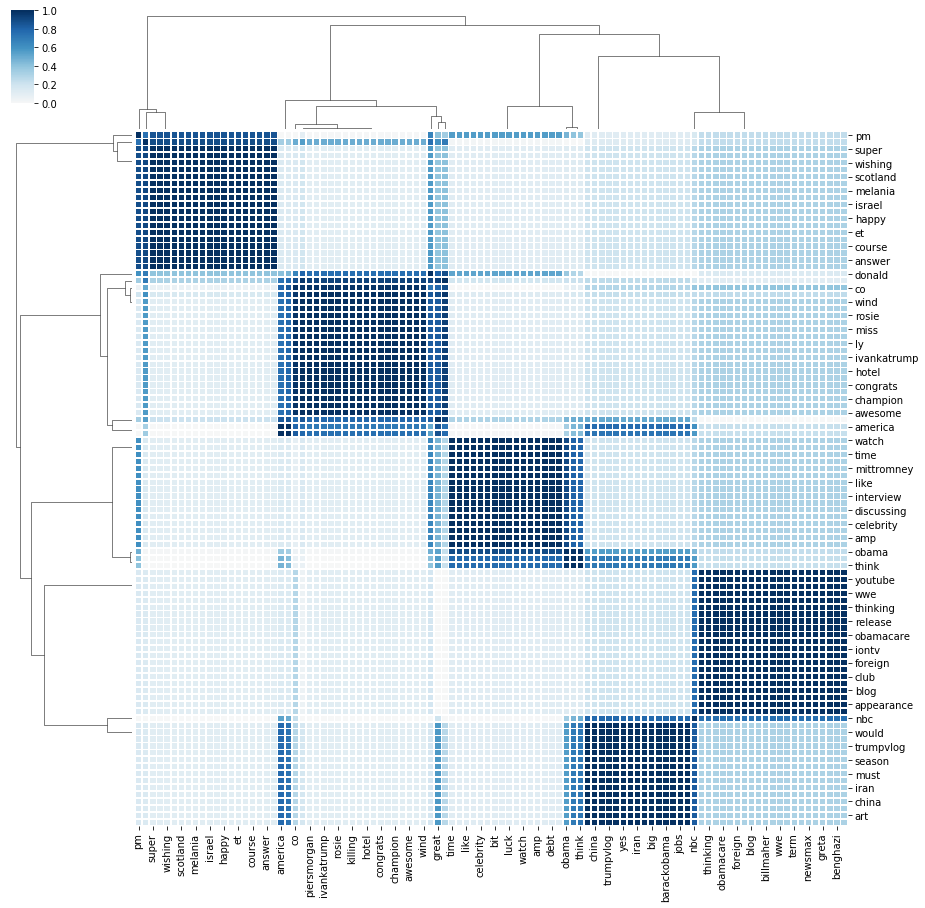

In [23]:
g=sns.clustermap(df_lda.corr(), 
                 center=0, 
                 standard_scale=1, 
                 cmap="RdBu", 
                 metric='cosine', 
                 linewidths=.75, 
                 figsize=(15, 15))

plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
#plt.show()
plt.savefig('heatmap.png')

In [18]:
# Let's try to predict one tweet for DT
unseen_tweets = [
'So good to see that Republicans will be winning the Great State of Alabama Senate Seat back, now that lightweight Senator @DougJones cast a partisan vote for the Impeachment Hoax. Thought his boss, Cryin’ Chuck, would have forced him to vote against the Hoax. A Do Nothing Stiff!',
'Tune in the apprentice tonight and see which the celebrity wins our TV show!',
'MAKE AMERICA GREAT AGAIN!' ]
corpus_exp = [l.preprocess_without_LS(tweet, 'realdonaldtrump') for tweet in unseen_tweets]
bow_corpus = [dictionary.doc2bow(text) for text in corpus_exp]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
unseen_corpus_lda = lda[corpus_tfidf[1]]
unseen_corpus_lda

[(0, 0.053571526),
 (1, 0.05386623),
 (2, 0.44646755),
 (3, 0.28753373),
 (4, 0.15856093)]

In [37]:
from gensim.test.utils import datapath

#temp_file = datapath("./LDAmodel_realDonaldTrump")
lda.save("./LDAmodel_realDonaldTrump")
dictionary.save("./dictionary_realDonaldTrump")

In [30]:
lda.top_topics(corpus=bow_corpus, dictionary=dictionary)

[([(0.010190033, u'happy'),
   (0.009138075, u'tonight'),
   (0.008960736, u'iran'),
   (0.008860577, u'thanks'),
   (0.008005042, u'realdonaldtrump'),
   (0.0073292893, u'art'),
   (0.0061913454, u'interview'),
   (0.006189391, u'discussing'),
   (0.006124005, u'obama'),
   (0.0057637887, u'iraq'),
   (0.0051706997, u'episode'),
   (0.0050414237, u'enjoy'),
   (0.004951091, u'deal'),
   (0.0046660155, u'trumpvlog'),
   (0.0045818407, u'attack'),
   (0.00454051, u'birthday'),
   (0.0043396596, u'must'),
   (0.0039711697, u'touch'),
   (0.003940248, u'amp'),
   (0.003852281, u'libya')],
  -2.5135966257404627),
 ([(0.009977762, u'great'),
   (0.009690983, u'amp'),
   (0.009452976, u'new'),
   (0.006610761, u'hotel'),
   (0.0055573923, u'get'),
   (0.005435335, u'people'),
   (0.005274761, u'must'),
   (0.0050813267, u'scotland'),
   (0.004806017, u'mittromney'),
   (0.004499825, u'work'),
   (0.0042421627, u'wind'),
   (0.004077586, u'york'),
   (0.004054434, u'tough'),
   (0.0037424627,

In [33]:
s = 'Ten years ago, Democrats made the single largest investment in student aid in U.S. history with the Student Aid & Fiscal Responsibility Act. Last week, we secured student borrower relief in the CARES Act & will prioritize student debt throughout this crisis. #FamiliesFirst'

In [34]:
print(s.split(" "))

['Ten', 'years', 'ago,', 'Democrats', 'made', 'the', 'single', 'largest', 'investment', 'in', 'student', 'aid', 'in', 'U.S.', 'history', 'with', 'the', 'Student', 'Aid', '&', 'Fiscal', 'Responsibility', 'Act.', 'Last', 'week,', 'we', 'secured', 'student', 'borrower', 'relief', 'in', 'the', 'CARES', 'Act', '&', 'will', 'prioritize', 'student', 'debt', 'throughout', 'this', 'crisis.', '#FamiliesFirst']


In [31]:
def get_user_model(username_case, l):
    username = username_case.lower()
    dataset = './data/{}_clean_tweets.csv'.format(username_case)
    tweets = pd.read_csv(dataset, encoding='latin1')
    corpus_DT = []
    for tweet in tweets['content']:
        corpus_DT.append(l.preprocess_without_LS(tweet, username))
    dictionary = corpora.Dictionary(corpus_DT)
    bow_corpus = [dictionary.doc2bow(text) for text in corpus_DT]
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]
    lda = models.LdaModel(corpus_tfidf, 
                      id2word=dictionary, 
                      num_topics=5)
    lda.save("../../resource/models/lda/{}/model".format(username_case, username_case))
    dictionary.save("../../resource/models/lda/{}/dictionary".format(username_case, username_case))
    

In [32]:
usernames = ['cnnbrk', 'HillaryClinton', 'SpeakerPelosi', 'BarackObama', 'JoeBiden', 'TomiLahren', 'BernieSanders', 'AOC', 'SenTedCruz']
l = LDAHelper()
for username in usernames:
    get_user_model(username, l)

In [18]:
pd.read_csv('./data/{}_clean_tweets.csv'.format('AOC'), encoding='latin1')

,content
0,Yes! And equal paternity/parental leave is jus...
1,Non-birthing parents are JUST as important.We ...
2,It takes a village. Leave isnât only about p...
3,This is a big deal.
4,Thank you @CPDAction for endorsing @BernieSand...
5,Together we will fight for an advanced multira...
6,Thrilled to be in this together https://twitte...
7,I go back and forth on whether to go on Fox News.
8,The main reason I havenât is squaring the fa...
9,âImmigrants are dirtyâ is a lazy tired rac...
